In this notebook, I will experiment with different schedulers, seeing which can improve the standard coursework 1 setup.

In [1]:
#Run experiments using fixed, list, newBob and exponential use different scheduler each loop

In [2]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperiments", writeback = True)


options = {1: 'Exponential', 2: 'Fixed', 3: 'NewBob', 4: 'List'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(0,2):
    #Go through for each learning rate
    for rate in xrange(1, 5):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)
        elif rate == 4:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            
            #Build this up instead
            lr_scheduler = LearningRateList(learningList,max_epochs=max_epochs)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_p[options[rate]+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting Exponential
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.624. Accuracy is 8.60%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.554. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 3.053. Accuracy is 58.00%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.600. Accuracy is 81.41%
INFO:mlp.schedulers:0.495024916875
INFO:mlp.optimisers:Epoch 2: Took 5 seconds. Training speed 411 pps. Validation speed 4657 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.516. Accuracy is 83.60%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.495. Accuracy is 85.13%
INFO:mlp.schedulers:0.490099336653
INFO:mlp.optimisers:Epoch 3: Took 4 seconds. Training speed 423 pps. Validation speed 4846 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.322. Accuracy is 91.10%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.45

Use 50 epochs, 0.01, 0.05, 0.1, 0.2, 0.5, 
Build the list from (start_rate / epochs), to have constant decrease otherwise it would return a 0 learning rate.
Always start from 0.5
Use both 1 and 2 layers and 3 layers as interested in different schedulers affects on depth of network.
Save the exponential decline, as well as list and newBobs rate.



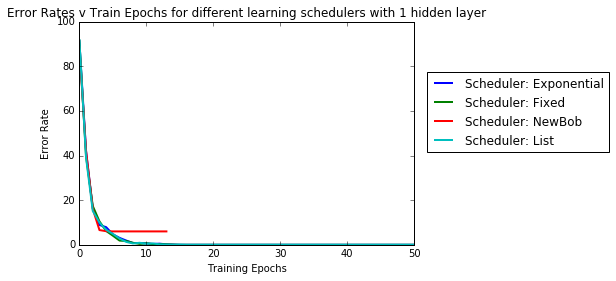

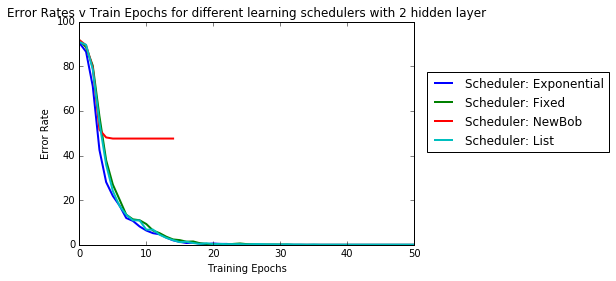

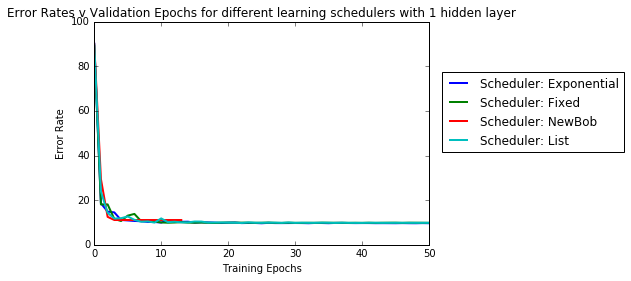

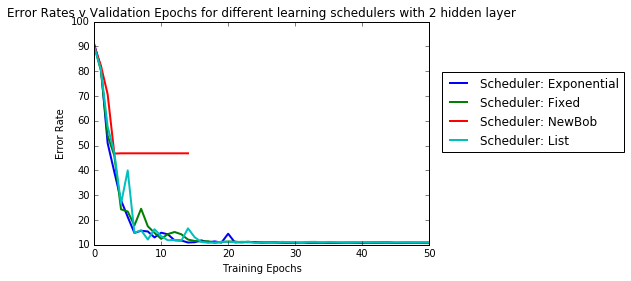

In [3]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['Exponential', 'Fixed', 'NewBob','List']

for i in xrange(0,2):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[0:len(shelve_p[lists+str(i)][0])], train_error[0:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
    
for i in xrange(0,2):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[0:len(shelve_p[lists+str(i)][0])], train_error[0:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

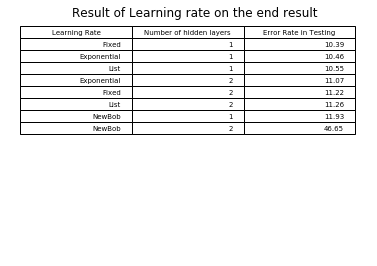

In [4]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
tracker = []

train_cont = ['Exponential', 'Fixed', 'NewBob','List']
for item in train_cont:
    for val in xrange(0,2):
        tracker.append([item,str(val+1), 100-(100*shelve_p[(item+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[2])
#Plot table, with these columns
columns = ('Learning Rate', 'Number of hidden layers', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of Learning rate on the end result')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()





Experiment with different newBob parameters, better with multiple layers

In [5]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperimentsNew", writeback = True)


options = {1: 'NewBob100', 2: 'NewBob50', 3: 'NewBob25'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(1,3):
    #Go through for each learning rate
    for rate in xrange(1, 4):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 100)
        elif rate == 2:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 50)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 25)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_p[options[rate]+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))
        

logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting NewBob100
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.411. Accuracy is 7.80%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.424. Accuracy is 7.91%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.672. Accuracy is 29.40%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.322. Accuracy is 50.92%
INFO:mlp.optimisers:Epoch 2: Took 6 seconds. Training speed 323 pps. Validation speed 3570 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.949. Accuracy is 66.90%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.686. Accuracy is 75.73%
INFO:mlp.optimisers:Epoch 3: Took 7 seconds. Training speed 316 pps. Validation speed 2932 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.483. Accuracy is 87.10%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.489. Accuracy is 86.30%
INFO:mlp.optimisers:Epoch 4: Took 6 seconds. Train

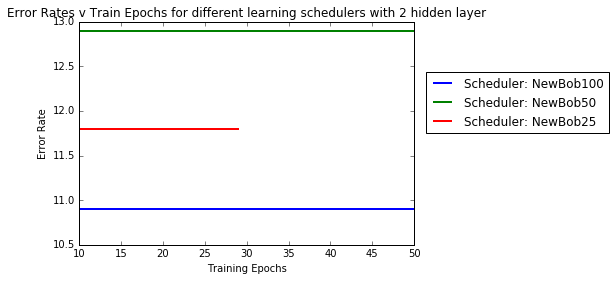

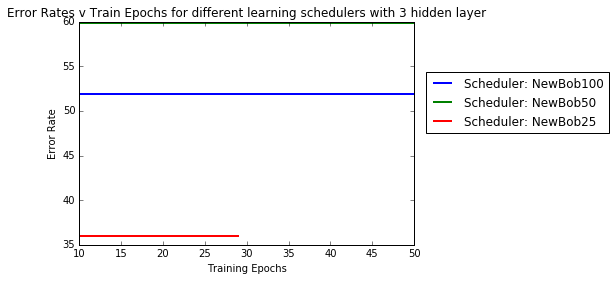

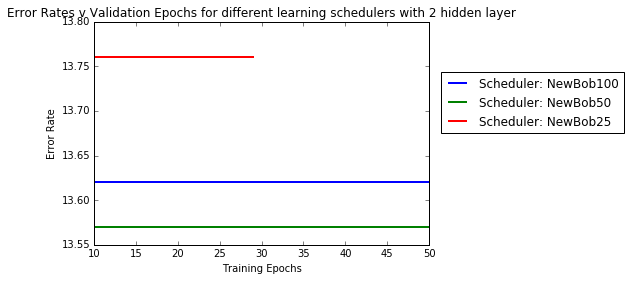

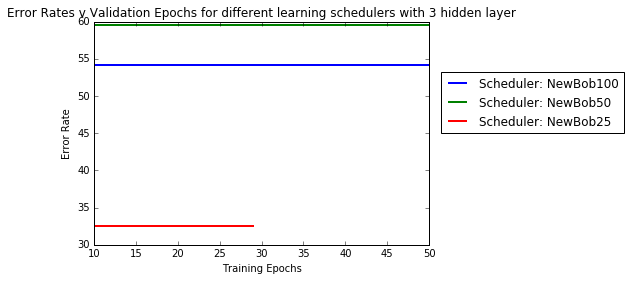

In [6]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperimentsNew")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['NewBob100', 'NewBob50', 'NewBob25']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

In [7]:
import shelve
shelve_p = shelve.open("learningRateExperimentsNew")

print shelve_p['NewBob1001']

([(2.4114701112295687, 0.077999999999999986), (2.6718967945709324, 0.29399999999999993), (0.94903864492988566, 0.66899999999999993), (0.48339937717083026, 0.87100000000000033), (0.43752767003056142, 0.89000000000000024), (0.4361273744711418, 0.89100000000000013), (0.43605667113971369, 0.89100000000000024), (0.43605334285394504, 0.89100000000000024), (0.43605317355197776, 0.89100000000000024), (0.43605316502125324, 0.89100000000000024), (0.43605316459560889, 0.89100000000000013), (0.4360531645738559, 0.89100000000000024), (0.43605316457278581, 0.89100000000000024), (0.43605316457273302, 0.89100000000000013), (0.43605316457273097, 0.89100000000000013), (0.43605316457273097, 0.89100000000000024), (0.43605316457273102, 0.89100000000000013), (0.43605316457273102, 0.8909999999999999), (0.43605316457273113, 0.89100000000000013), (0.43605316457273102, 0.89100000000000013), (0.43605316457273102, 0.89100000000000024), (0.43605316457273102, 0.89100000000000013), (0.43605316457273097, 0.8910000000

NewBob - Scale by half instead of a 20th, min difference is 0.05 still

In [8]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperiments")


options = {1: 'NewBob100', 2: 'NewBob50', 3: 'NewBob25'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(1,3):
    #Go through for each learning rate
    for rate in xrange(1, 4):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.5, zero_rate=learning_rate, patience = 100)
        elif rate == 2:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.5, zero_rate=learning_rate, patience = 50)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.5, zero_rate=learning_rate, patience = 25)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_p[options[rate]+'H'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting NewBob100
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.411. Accuracy is 7.80%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.424. Accuracy is 7.91%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.672. Accuracy is 29.40%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.322. Accuracy is 50.92%
INFO:mlp.optimisers:Epoch 2: Took 6 seconds. Training speed 312 pps. Validation speed 3391 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.949. Accuracy is 66.90%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.686. Accuracy is 75.73%
INFO:mlp.optimisers:Epoch 3: Took 6 seconds. Training speed 305 pps. Validation speed 3263 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.477. Accuracy is 85.00%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.503. Accuracy is 84.23%
INFO:mlp.optimisers:Epoch 4: Took 7 seconds. Train

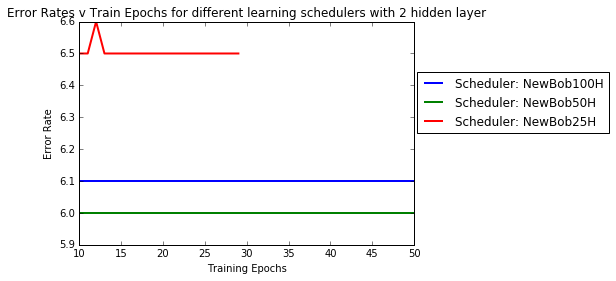

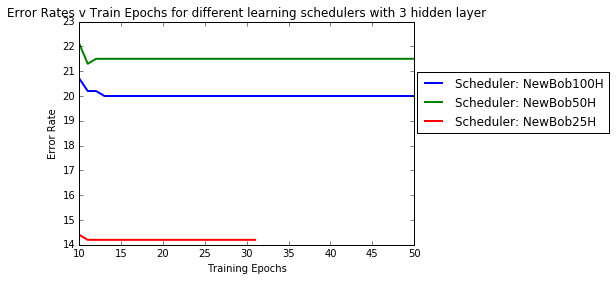

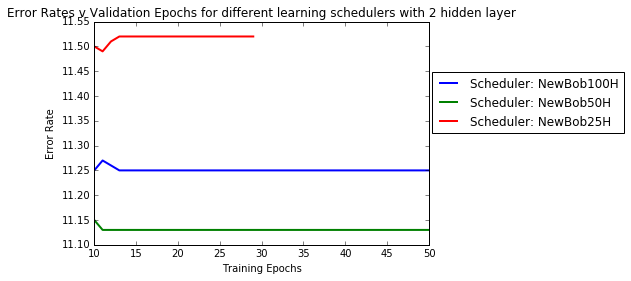

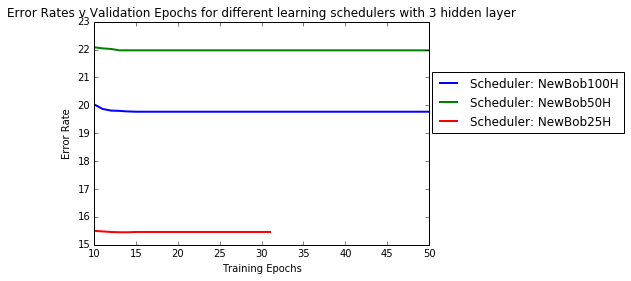

In [9]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['NewBob100H', 'NewBob50H', 'NewBob25H']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

In [10]:
import shelve
shelve_p = shelve.open("learningRateExperiments")

print shelve_p['NewBob25H2']

([(2.5011409472383841, 0.11199999999999999), (2.6351668621126016, 0.13300000000000001), (1.991006561995267, 0.28199999999999997), (1.1456042931205619, 0.59599999999999997), (0.78547991864360811, 0.74200000000000021), (0.64633002463903466, 0.81600000000000028), (0.59445299942478491, 0.84300000000000008), (0.55985601621406889, 0.8540000000000002), (0.54716428382172078, 0.8490000000000002), (0.54001009144752432, 0.8580000000000001), (0.53622848195010731, 0.85600000000000021), (0.53420531383525971, 0.8580000000000001), (0.53324064214024625, 0.8580000000000001), (0.53274828544362296, 0.8580000000000001), (0.53250813490969107, 0.85799999999999998), (0.53238892363656465, 0.8580000000000001), (0.53232461810968923, 0.8580000000000001), (0.53229254303471552, 0.8580000000000001), (0.53227747460605057, 0.85799999999999998), (0.53226983378881232, 0.8580000000000001), (0.53226611511687338, 0.85800000000000021), (0.53226414374399178, 0.85799999999999998), (0.53226313238769118, 0.85800000000000021), (

Different exponential rates

In [11]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperiments")


options = {1: 'Exponential05', 2: 'Exponential06', 3: 'Exponential07'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(1,3):
    #Go through for each learning rate
    for rate in xrange(1, 4):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=0.5, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateExponential(start_rate=0.6, max_epochs=max_epochs, training_size=100)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateExponential(start_rate=0.7, max_epochs=max_epochs, training_size=100)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_p[options[rate]+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting Exponential05
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.411. Accuracy is 7.80%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.424. Accuracy is 7.91%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.672. Accuracy is 29.40%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.322. Accuracy is 50.92%
INFO:mlp.schedulers:0.495024916875
INFO:mlp.optimisers:Epoch 2: Took 6 seconds. Training speed 317 pps. Validation speed 3381 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.946. Accuracy is 66.90%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.686. Accuracy is 75.73%
INFO:mlp.schedulers:0.490099336653
INFO:mlp.optimisers:Epoch 3: Took 6 seconds. Training speed 318 pps. Validation speed 3628 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.578. Accuracy is 80.70%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.

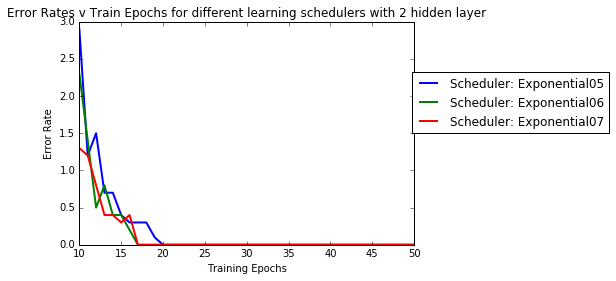

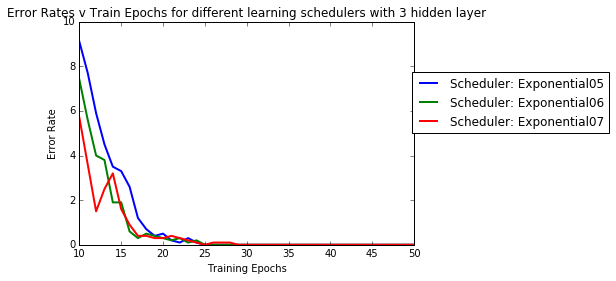

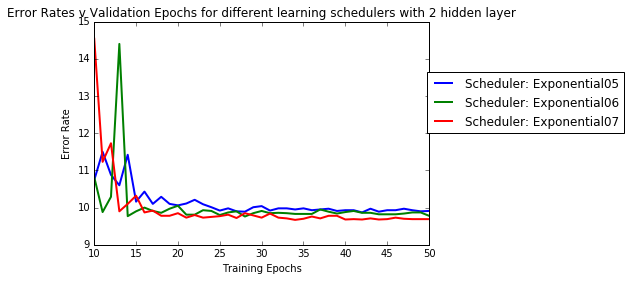

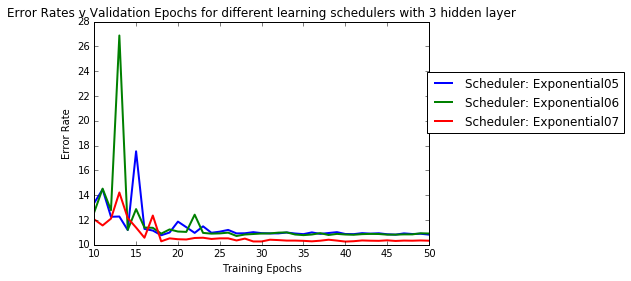

In [12]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['Exponential05', 'Exponential06', 'Exponential07']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

New Bob with half for min error and learning rate

In [13]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperimentsNew", writeback = True)


options = {1: 'NewBob100', 2: 'NewBob50', 3: 'NewBob25'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(1,3):
    #Go through for each learning rate
    for rate in xrange(1, 4):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.5, scale_by=0.5, zero_rate=learning_rate, patience = 100)
        elif rate == 2:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.5, scale_by=0.5, zero_rate=learning_rate, patience = 50)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.5, scale_by=0.5, zero_rate=learning_rate, patience = 25)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_p[options[rate]+'HH'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting NewBob100
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.411. Accuracy is 7.80%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.424. Accuracy is 7.91%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.672. Accuracy is 29.40%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.322. Accuracy is 50.92%
INFO:mlp.optimisers:Epoch 2: Took 6 seconds. Training speed 320 pps. Validation speed 3649 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.949. Accuracy is 66.90%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.686. Accuracy is 75.73%
INFO:mlp.optimisers:Epoch 3: Took 6 seconds. Training speed 323 pps. Validation speed 3654 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.477. Accuracy is 85.00%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.503. Accuracy is 84.23%
INFO:mlp.optimisers:Epoch 4: Took 6 seconds. Train

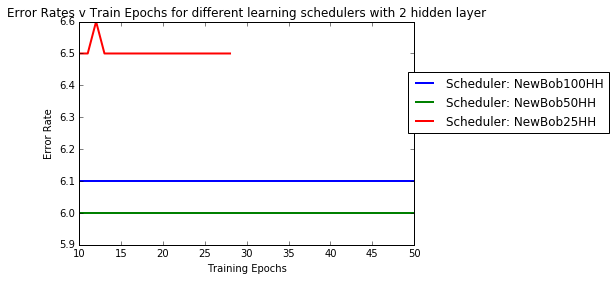

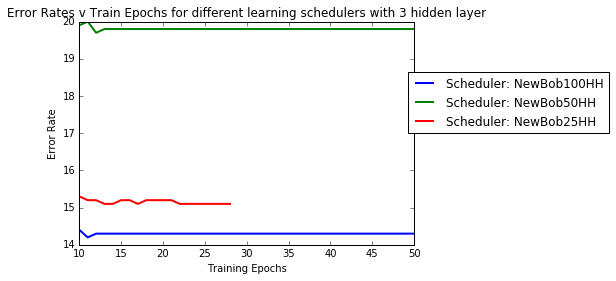

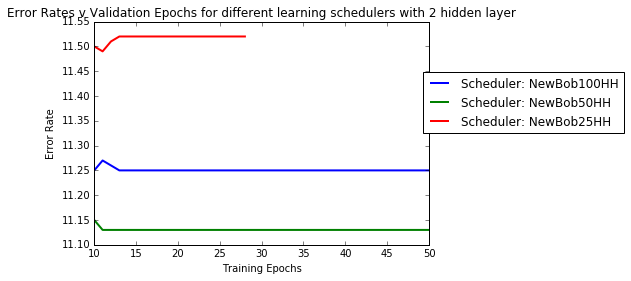

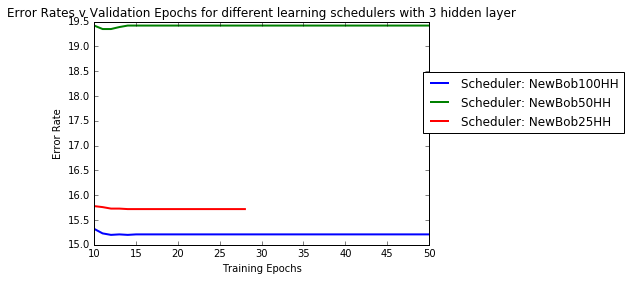

In [14]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperimentsNew")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['NewBob100HH', 'NewBob50HH', 'NewBob25HH']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

NewBob experiments with 10 epochs

In [15]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperiments")


options = {1: 'NewBob10', 2: 'NewBob10'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(1,3):
    #Go through for each learning rate
    for rate in xrange(1, 3):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.5, zero_rate=learning_rate, patience = 10)
        elif rate == 2:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.5, scale_by=0.5, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        if rate == 1:
            shelve_p[options[rate]+'H'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))
        if rate == 2:
            shelve_p[options[rate]+'HH'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))
            
logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting NewBob10
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.411. Accuracy is 7.80%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.424. Accuracy is 7.91%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.672. Accuracy is 29.40%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.322. Accuracy is 50.92%
INFO:mlp.optimisers:Epoch 2: Took 5 seconds. Training speed 382 pps. Validation speed 3481 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.949. Accuracy is 66.90%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.686. Accuracy is 75.73%
INFO:mlp.optimisers:Epoch 3: Took 6 seconds. Training speed 373 pps. Validation speed 3419 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.477. Accuracy is 85.00%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.503. Accuracy is 84.23%
INFO:mlp.optimisers:Epoch 4: Took 6 seconds. Traini

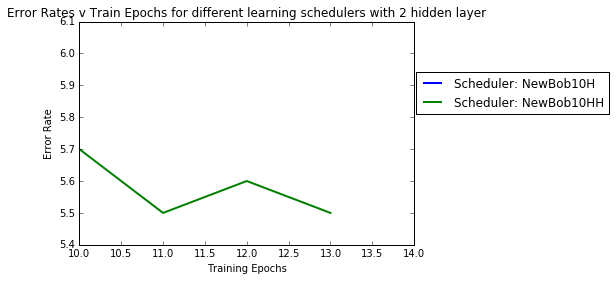

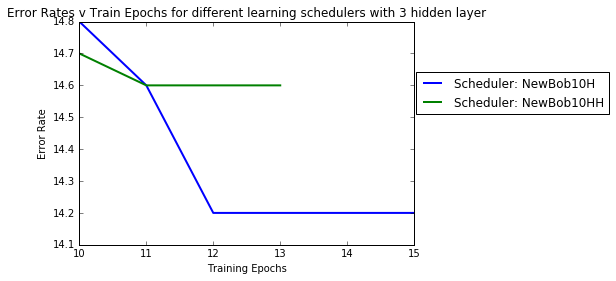

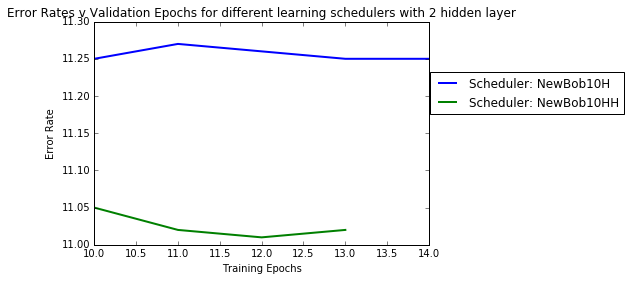

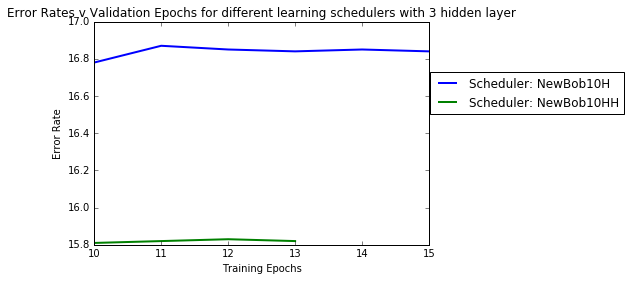

In [16]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperiments")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['NewBob10H', 'NewBob10HH']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

In [17]:
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()

learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)
#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_p = shelve.open("learningRateExperimentsExpZ")


options = {1: 'ExponentialZ05', 2: 'ExponentialZ06', 3: 'ExponentialZ07'}

stats = []

#For each number of layers, new model add layers.
for layer in xrange(1,3):
    #Go through for each learning rate
    for rate in xrange(1, 4):

        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting " + options[rate])

        #define the model
        model = MLP(cost=cost)
        
        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        if layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=400, odim=odim, irange=0.2, rng=rng))
        
        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=0.5, max_epochs=max_epochs, training_size=100, zero_rate = 0.5)
        elif rate == 2:
            lr_scheduler = LearningRateExponential(start_rate=0.5, max_epochs=max_epochs, training_size=100, zero_rate = 0.6)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateExponential(start_rate=0.5, max_epochs=max_epochs, training_size=100, zero_rate = 0.7)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_p[options[rate]+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_p.close()   

INFO:root:Initialising data providers...
INFO:root:Starting ExponentialZ05
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.411. Accuracy is 7.80%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.424. Accuracy is 7.91%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.672. Accuracy is 29.40%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.322. Accuracy is 50.92%
INFO:mlp.schedulers:0.495024916875
INFO:mlp.optimisers:Epoch 2: Took 6 seconds. Training speed 317 pps. Validation speed 3254 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.946. Accuracy is 66.90%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.686. Accuracy is 75.73%
INFO:mlp.schedulers:0.490099336653
INFO:mlp.optimisers:Epoch 3: Took 7 seconds. Training speed 297 pps. Validation speed 2780 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.578. Accuracy is 80.70%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0

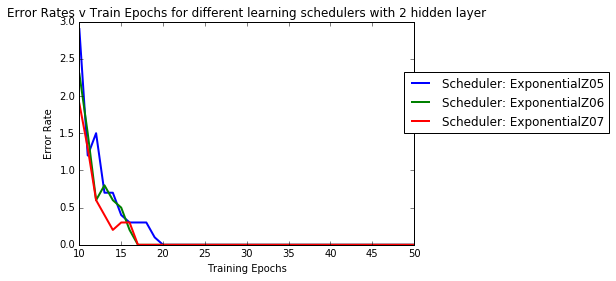

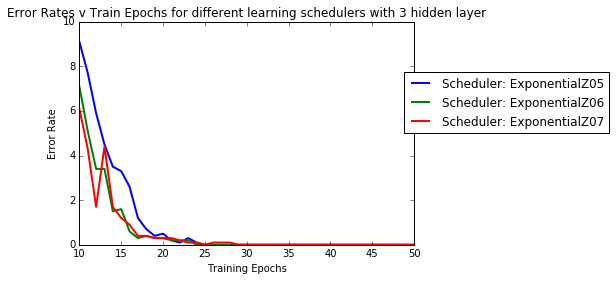

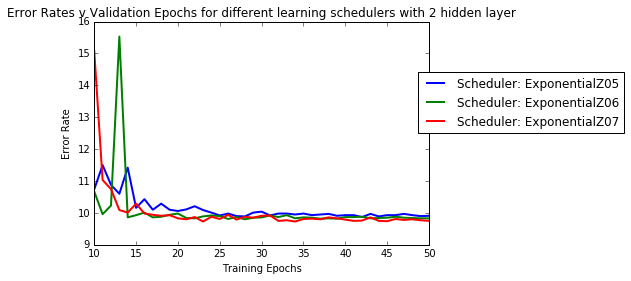

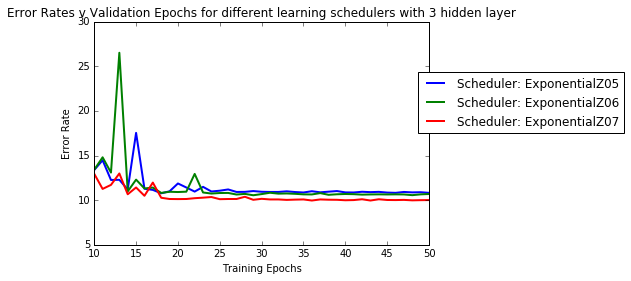

In [18]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("learningRateExperimentsExpZ")
x = range(0,51)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['ExponentialZ05', 'ExponentialZ06', 'ExponentialZ07']

for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
for i in xrange(1,3):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x[10:len(shelve_p[lists+str(i)][0])], train_error[10:len(shelve_p[lists+str(i)][0])], lw=2, label="Scheduler: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different learning schedulers with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()